In [1]:
from time import perf_counter
import numpy as np,os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, power_transform, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.pipeline import make_pipeline, Pipeline
import seaborn as sns,matplotlib.pyplot as plt

from library.configs import CLFS, IMBS, CV, SCORERS
from library.utils import evaluate, read_data

/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-pack

In [3]:
DATASETS = ['groovy-1_5_7.csv','jruby-1.4.0.csv','lucene-2.9.0.csv','jruby-1.7.0.preview1.csv','groovy-1_6_BETA_1.csv',
        'derby-10.2.1.6.csv','wicket-1.5.3.csv','camel-2.9.0.csv','camel-1.4.0.csv','activemq-5.8.0.csv']
#DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]
len(DATASETS)

10

In [4]:
NOISE_TYPES = ['No','FN-Only','FP-Only','Both']
CV = RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=99)

In [5]:
models = {}
for im,samp in IMBS.items():
    for c,clf in CLFS.items():
        models[(im,c)] = Pipeline([('samp',samp),('clf',clf)])
models.keys(),len(models)

(dict_keys([('smote', 'dt'), ('smote', 'lr'), ('smote', 'nb'), ('smote', 'svm'), ('smote', 'knn'), ('smote', 'rf'), ('rus', 'dt'), ('rus', 'lr'), ('rus', 'nb'), ('rus', 'svm'), ('rus', 'knn'), ('rus', 'rf'), ('wilson', 'dt'), ('wilson', 'lr'), ('wilson', 'nb'), ('wilson', 'svm'), ('wilson', 'knn'), ('wilson', 'rf'), ('tomek', 'dt'), ('tomek', 'lr'), ('tomek', 'nb'), ('tomek', 'svm'), ('tomek', 'knn'), ('tomek', 'rf'), ('None', 'dt'), ('None', 'lr'), ('None', 'nb'), ('None', 'svm'), ('None', 'knn'), ('None', 'rf')]),
 30)

In [ ]:
cols = pd.MultiIndex.from_product([NOISE_TYPES,IMBS.keys(),CLFS.keys(),[f.__name__ for f in SCORERS]],names=['noise','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)

In [8]:
from sklearn.metrics import confusion_matrix
FRACS = [0,.25,.5,.75,1.0]
cols = pd.MultiIndex.from_product([FRACS,IMBS.keys(),CLFS.keys(),[f.__name__ for f in SCORERS]],names=['frac','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)
for it,d in enumerate(DATASETS):
    X,y_noisy,y_real = read_data(d,stats=True)
    C = np.argwhere(y_real==1).ravel()
    N = np.argwhere(y_noisy==0).ravel()  #FP
    idx = np.intersect1d(N,C)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    print("idx:",len(idx),fn,len(N),len(C))
    for frac in FRACS:
        print("frac:",frac)
        y = y_noisy.copy()
        size = int(frac*len(idx))
        to_correct = np.random.choice(idx.copy(),size=size,replace=False)
        y[to_correct] = 1
        print(len(idx),len(to_correct))
        print(f"{precision_score(y_real,y):.3f},{recall_score(y_real,y):.3f}",(y_real!=y).sum())
        
        for k in models:
            r = evaluate(models[k],X,y,y_real,CV,SCORERS)
            for f in r:
                df.loc[d,(frac,k[0],k[1],f)] = r[f].mean()
    df.to_csv("FN.csv")

groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
idx: 5 5 677 26
frac: 0
5 0
0.263,0.808 64
frac: 0.25
5 1
0.272,0.846 63
frac: 0.5
5 2
0.280,0.885 62
frac: 0.75
5 3
0.289,0.923 61
frac: 1.0
5 5
0.306,1.000 59
jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)
idx: 83 83 778 180
frac: 0
83 0
0.485,0.539 186
frac: 0.25
83 20
0.532,0.650 166
frac: 0.5
83 41
0.573,0.767 145
frac: 0.75
83 62
0.607,0.883 124
frac: 1.0
83 83
0.636,1.000 103
lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)
idx: 152 152 1090 273
frac: 0
152 0
0.435,0.443 309
frac: 0.25
152 38
0.503,0.582 271
frac: 0.5
152 76
0.556,0.722 233
frac: 0.75
152 114
0.599,0.861 195
frac: 1.0
152 152
0.635,1.000 157
jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)
idx: 42 42 1451 87
frac: 0
42 0
0.276,0.517 160
frac: 0.25
42 10
0.318,0.632 150
frac: 0.5
42 21
0.359,0.759 139
frac: 0.75
42 31
0.392,0.874 129
frac: 1.0
42 42
0.424,1.000 118
groovy-1_6_BETA_1.csv noi

/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


frac: 0.25
525 131
0.859,0.404 438
frac: 0.5
525 262
0.900,0.602 307
frac: 0.75
525 393
0.923,0.800 176
frac: 1.0
525 525
0.938,1.000 44
wicket-1.5.3.csv noise:0.064, imb:26.720,93,2485, Shape:(2578, 65)
idx: 89 89 2485 105
frac: 0
89 0
0.172,0.152 166


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.25
89 22
0.330,0.362 144


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


frac: 0.5
89 44
0.438,0.571 122


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.75
89 66
0.516,0.781 100


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


frac: 1.0
89 89
0.577,1.000 77
camel-2.9.0.csv noise:0.044, imb:34.600,200,6920, Shape:(7120, 65)
idx: 156 156 6920 199
frac: 0
156 0
0.215,0.216 313


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.25
156 39
0.343,0.412 274


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


frac: 0.5
156 78
0.435,0.608 235
frac: 0.75
156 117
0.505,0.804 196
frac: 1.0
156 156
0.559,1.000 157
camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)
idx: 174 174 1152 285
frac: 0
174 0
0.306,0.389 426
frac: 0.25
174 43
0.379,0.540 383
frac: 0.5
174 87
0.440,0.695 339
frac: 0.75
174 130
0.489,0.846 296
frac: 1.0
174 174
0.531,1.000 252
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)
idx: 100 100 3217 206
frac: 0
100 0
0.522,0.515 197
frac: 0.25
100 25
0.575,0.636 172
frac: 0.5
100 50
0.617,0.757 147
frac: 0.75
100 75
0.651,0.879 122
frac: 1.0
100 100
0.680,1.000 97


In [9]:
from sklearn.metrics import confusion_matrix
FRACS = [0,.25,.5,.75,1.0]
cols = pd.MultiIndex.from_product([FRACS,IMBS.keys(),CLFS.keys(),[f.__name__ for f in SCORERS]],names=['frac','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)
for it,d in enumerate(DATASETS):
    X,y_noisy,y_real = read_data(d,stats=True)
    C = np.argwhere(y_real==0).ravel()
    N = np.argwhere(y_noisy==1).ravel()  #FP
    idx = np.intersect1d(N,C)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    print("idx:",len(idx),fn,len(N),len(C))
    for frac in FRACS:
        print("frac:",frac)
        y = y_noisy.copy()
        size = int(frac*len(idx))
        to_correct = np.random.choice(idx.copy(),size=size,replace=False)
        y[to_correct] = 0
        print(len(idx),len(to_correct))
        print(f"{precision_score(y_real,y):.3f},{recall_score(y_real,y):.3f}",(y_real!=y).sum())
        
        for k in models:
            r = evaluate(models[k],X,y,y_real,CV,SCORERS)
            for f in r:
                df.loc[d,(frac,k[0],k[1],f)] = r[f].mean()
    df.to_csv("FP.csv")

groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
idx: 59 5 80 731
frac: 0
59 0
0.263,0.808 64
frac: 0.25
59 14
0.318,0.808 50
frac: 0.5
59 29
0.412,0.808 35
frac: 0.75
59 44
0.583,0.808 20
frac: 1.0
59 59
1.000,0.808 5


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)
idx: 103 83 200 798
frac: 0
103 0
0.485,0.539 186
frac: 0.25
103 25
0.554,0.539 161
frac: 0.5
103 51
0.651,0.539 135
frac: 0.75
103 77
0.789,0.539 109
frac: 1.0
103 103
1.000,0.539 83
lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)
idx: 157 152 278 1095
frac: 0
157 0
0.435,0.443 309
frac: 0.25
157 39
0.506,0.443 270
frac: 0.5
157 78
0.605,0.443 231
frac: 0.75
157 117
0.752,0.443 192
frac: 1.0
157 157
1.000,0.443 152
jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)
idx: 118 42 163 1527
frac: 0
118 0
0.276,0.517 160
frac: 0.25
118 29
0.336,0.517 131
frac: 0.5
118 59
0.433,0.517 101
frac: 0.75
118 88
0.600,0.517 72
frac: 1.0
118 118
1.000,0.517 42


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
idx: 76 29 117 751
frac: 0
76 0
0.350,0.586 105
frac: 0.25
76 19
0.418,0.586 86
frac: 0.5
76 38
0.519,0.586 67
frac: 0.75
76 57
0.683,0.586 48


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


frac: 1.0
76 76
1.000,0.586 29


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

derby-10.2.1.6.csv noise:0.290, imb:9.906,180,1783, Shape:(1963, 65)
idx: 44 525 180 1302
frac: 0
44 0
0.756,0.206 569
frac: 0.25
44 11
0.805,0.206 558
frac: 0.5
44 22
0.861,0.206 547
frac: 0.75
44 33
0.925,0.206 536


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


frac: 1.0
44 44
1.000,0.206 525
wicket-1.5.3.csv noise:0.064, imb:26.720,93,2485, Shape:(2578, 65)
idx: 77 89 93 2473
frac: 0
77 0
0.172,0.152 166


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.25
77 19
0.216,0.152 147


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.5
77 38
0.291,0.152 128


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.75
77 57
0.444,0.152 109


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 1.0
77 77
1.000,0.152 89


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

camel-2.9.0.csv noise:0.044, imb:34.600,200,6920, Shape:(7120, 65)
idx: 157 156 200 6921
frac: 0
157 0
0.215,0.216 313


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.25
157 39
0.267,0.216 274


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.5
157 78
0.352,0.216 235


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 0.75
157 117
0.518,0.216 196


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

frac: 1.0
157 157
1.000,0.216 156


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/metrics/_classification.py:896: RuntimeWarning: invalid value encountered in double_scalars
  mcc = 

camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)
idx: 252 174 363 1230
frac: 0
252 0
0.306,0.389 426
frac: 0.25
252 63
0.370,0.389 363
frac: 0.5
252 126
0.468,0.389 300
frac: 0.75
252 189
0.638,0.389 237
frac: 1.0
252 252
1.000,0.389 174
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)
idx: 97 100 203 3214
frac: 0
97 0
0.522,0.515 197
frac: 0.25
97 24
0.592,0.515 173
frac: 0.5
97 48
0.684,0.515 149
frac: 0.75
97 72
0.809,0.515 125
frac: 1.0
97 97
1.000,0.515 100


In [ ]:
# for k in models:
#     print(k)
#     st = perf_counter()
#     for it,d in enumerate(DATASETS):
#         print(it)
#         X,y_noisy,y_real = read_data(d,stats=True)
#         for noise_type in NOISE_TYPES:
#             if df.loc[d,(noise_type,k[0],k[1],slice(None))].isna().sum()==0:
#                 print("SKipping...",d,(noise_type,k[0],k[1]))
#                 continue
#             y = y_noisy.copy()
#             if noise_type=='No':
#                 y = y_real.copy()
#             elif noise_type=='Both':
#                 pass
#             elif noise_type=='FP-Only':  #So recall 1.0
#                 y[y_real==1] = 1
#             elif noise_type=='FN-Only':  #So precision 1.0
#                 y[y_real==0] = 0
#             p = precision_score(y_real,y)
#             r = recall_score(y_real,y)
#             print(noise_type,p,r)
                
#             r = evaluate(models[k],X,y,y_real,CV,SCORERS)
#             for f in r:
#                 df.loc[d,(noise_type,k[0],k[1],f)] = r[f].mean()
#             #print(noise_type,df.loc[d,(noise_type,k[0],k[1],slice(None))],'\n')
#         print()
#         df.to_csv("FP vs FN Noise Impact.csv")
#     print(perf_counter()-st,'\n')

## Analysis

## Notes
1. Both `pr_rec_score` & `matthews_corrcoef`: As expected, "No" noise performs best, while "Both" worst, in terms of whole avg.
2. Interestingly, "Bug" i.e. (So recall=1.0) always performs better than "Non-Bug" i.e. (So precision=1.0)
3. Avg Rank: pr_rec_score- `[1.74, 1.95, 2.82, 3.48]`, Mathew- `[1.78 , 2.46, 2.59, 3.17]`   (['No','Bug','Non-Bug','Both'] in that serial)
4. So for Mathew, in terms of Avg Rank, Non-bug is better, contradicting point 2

In [82]:
import numpy as np
import pandas as pd,os
from scipy.stats import wilcoxon, friedmanchisquare, rankdata, trim_mean, linregress
import scikit_posthocs as sp
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
FN = pd.read_csv("FN.csv",header=[0,1,2,3],index_col=0)
FP = pd.read_csv("FP.csv",header=[0,1,2,3],index_col=0)

In [87]:

FN = FN.drop(columns=['matthews_corrcoef'],level=3,axis=1).droplevel(3,axis=1)
FP = FP.drop(columns=['matthews_corrcoef'],level=3,axis=1).droplevel(3,axis=1)
FP.shape,FN.shape

((10, 150), (10, 150))

In [88]:
FRACS = [0.,.25,.5,.75,1.0]
fn,fp = {},{}
for c in FRACS:
    fn[c] = trim_mean(FN[str(c)].values.reshape(-1),.05)
    fp[c] = trim_mean(FP[str(c)].values.reshape(-1),.05)
    print(c)

0.0
0.25
0.5
0.75
1.0


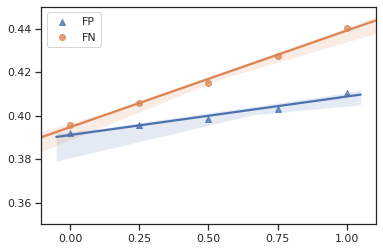

In [98]:
X = list(fp.keys())
plt.ylim(.35,.45)
plt.xticks(FRACS)
sns.regplot(X,list(fp.values()),ci=99,label='FP',marker='^');
sns.regplot(X,list(fn.values()),ci=99,label='FN');
plt.legend();
plt.savefig('figures/APRC.png')

In [79]:
meth = 'spearman'
pg.corr(X,list(fp.values()),method=meth)

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,5,0.9,"[0.09, 0.99]",0.81,0.62,0.037386,0.62


In [80]:
pg.corr(X,list(fn.values()),method=meth)

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,5,1.0,"[1.0, 1.0]",1.0,1.0,1.404265e-24,1.0


In [91]:
linregress(X,list(fn.values()))

LinregressResult(slope=0.04438982169353936, intercept=0.39468591993733915, rvalue=0.9978277612033258, pvalue=0.0001214936689052822, stderr=0.0016919985848454285)

In [92]:
linregress(X,list(fp.values()))

LinregressResult(slope=0.017675461504114944, intercept=0.39107955937572014, rvalue=0.9807694412017969, pvalue=0.003192015407844983, stderr=0.002030748422901834)